# **Phase space reconstruction with time-delay embedding**

---



Import libraries and repository

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D
from ESN import esnet
import json
from sklearn.decomposition import PCA

%matplotlib notebook

Lorenz system definition

In [2]:
# define the initial system state (aka x1, x2, x3 positions in space)
initial_state = [0.1, 0, 0]

# define the system parameters sigma, rho, and beta
sigma = 10.
rho   = 28.
beta  = 8./3.

# Lorenz system differential equations
def lorenz_system(current_state, t):
    x1, x2, x3 = current_state
    dx1_dt = sigma * (x2 - x1)
    dx2_dt = x1 * (rho - x3) - x2
    dx3_dt = x1 * x2 - beta * x3
    return [dx1_dt, dx2_dt, dx3_dt]

Obtain the time series of the system's trajectory by integrating the system. We assume only the time series of the first variable is observed

<IPython.core.display.Javascript object>


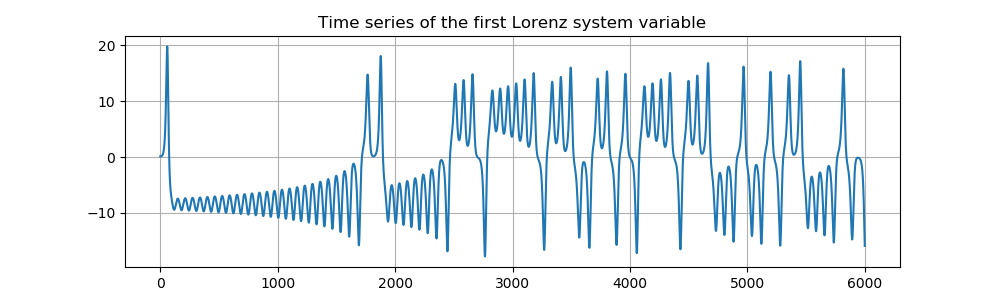

In [3]:
# define the time points to solve for, evenly spaced between the start and end times
start_time = 1
end_time = 60
interval = 100
time_points = np.linspace(start_time, end_time, end_time * interval)

Y = odeint(lorenz_system, initial_state, time_points) # trajectory of the whole system
y = Y[:,0] # observed time series

fig = plt.figure(figsize=(10,3))
plt.plot(y)
plt.grid()
plt.title("Time series of the first Lorenz system variable")
plt.show()

Generate time delay embeddings

<IPython.core.display.Javascript object>


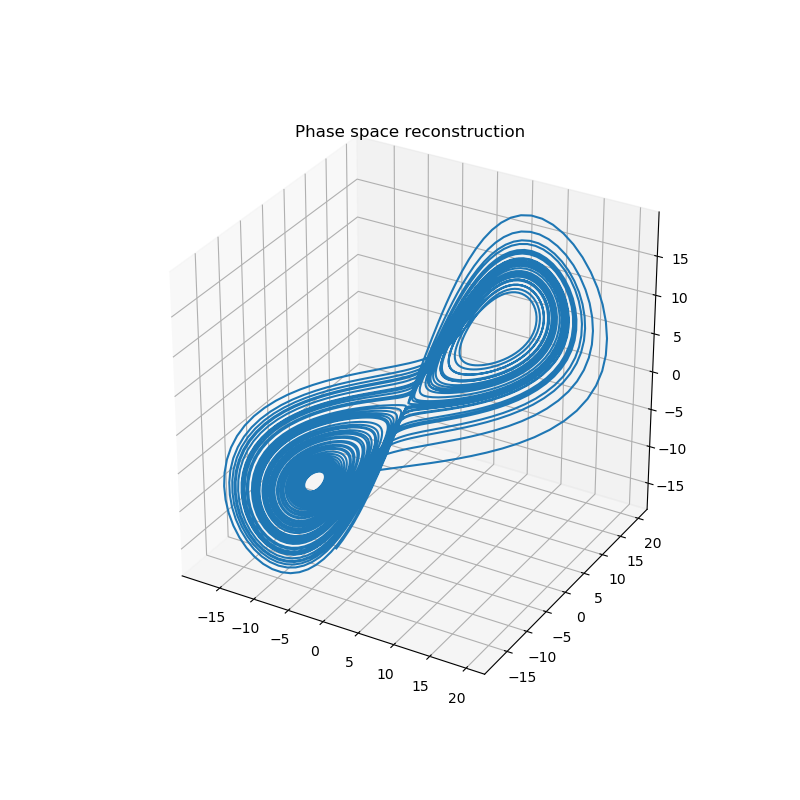

In [4]:
tau = 7 # time-delay

# Get delayed time series. 
# We know that the embedding dimension for Lorenz is 3, so we generate 3 delays
d1 = y[:-2*tau]
d2 = y[tau:-tau]
d3 = y[2*tau:]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(d1, d2, d3)
plt.title("Phase space reconstruction")
plt.show()

---

# **Phase space reconstruction from ESN states**

---

<IPython.core.display.Javascript object>


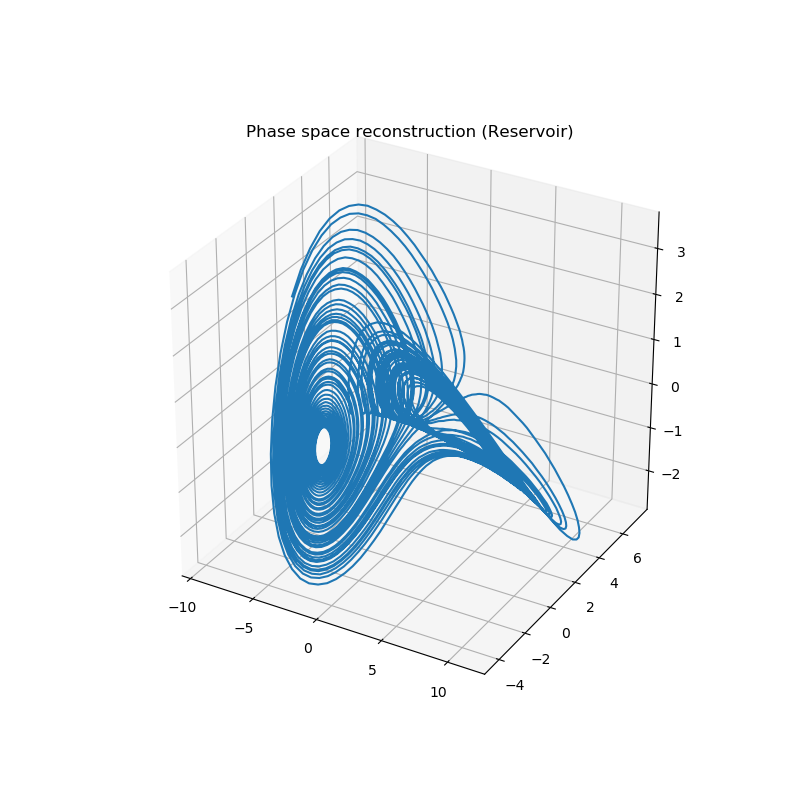

In [5]:
# Compute reservoir states
reservoir = esnet.ESN(n_internal_units = 400, spectral_radius = .7, input_scaling=.05)
reservoir.fit(Y,Y)
states, _, _ = reservoir._compute_state_matrix(Y)

# Apply dimensionality reduction
pca = PCA(n_components=3)
states_pca = pca.fit_transform(states)

# Plot the first 3 principal components
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(states_pca[:,0], states_pca[:,1], states_pca[:,2])
plt.title("Phase space reconstruction (Reservoir)")
plt.show()

# **Time series forecasting with ESN**

Load a time series of electricity load

<IPython.core.display.Javascript object>


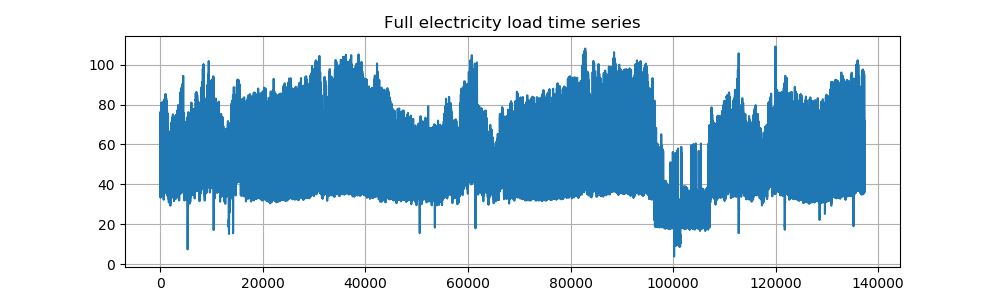

In [6]:
ts_full = scipy.io.loadmat("TS_Acea.mat")["X"]
fig = plt.figure(figsize=(10,3))
plt.plot(ts_full)
plt.grid()
plt.title("Full electricity load time series")
plt.show()

For the sake of visualization, we consider only the load of 2 weeks 

<IPython.core.display.Javascript object>


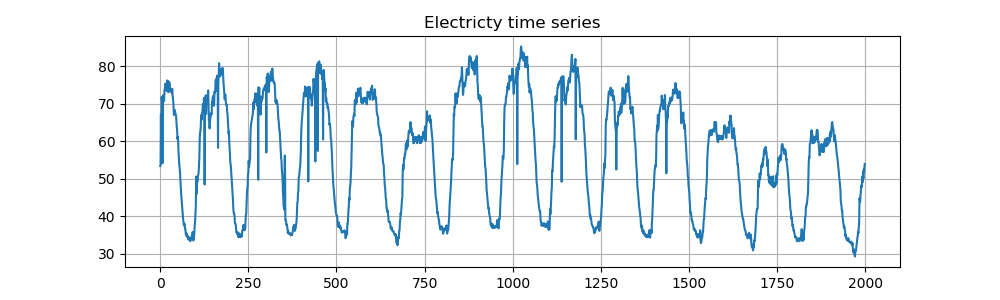

In [7]:
N = 2000
ts = ts_full[:N,:]

fig = plt.figure(figsize=(10,3))
plt.plot(ts)
plt.grid()
plt.title("Electricty time series")
plt.show()

Predict the load for the next 2 days

Test MSE 0.135


<IPython.core.display.Javascript object>


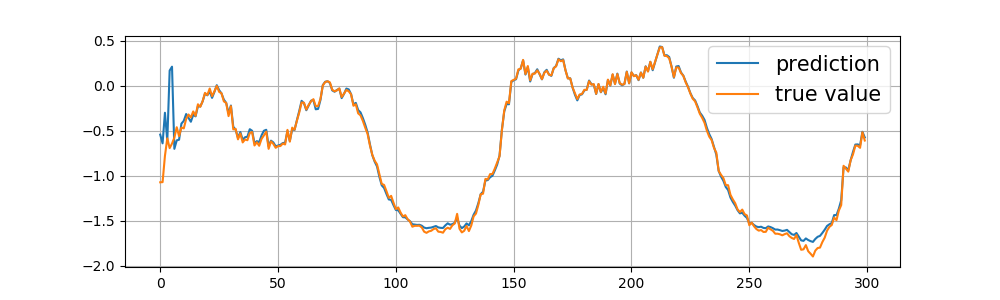

In [8]:
# Set ESN hyperparams
config = json.load(open('ESN/configs/esn/ESN_hyperparams.json', 'r'))

forecast_horizon = 6 # forecast horizon (1 = 10 mins)
Xtr, Ytr, _, _, Xte, Yte = esnet.generate_datasets(ts[forecast_horizon:,:], ts[:-forecast_horizon,:], test_percent = 0.15, val_percent = 0.01)

# Train and compute predictions
Yte_pred, te_error = esnet.run_from_config(Xtr, Ytr, Xte, Yte, config)
print('Test MSE {:.3f}'.format(te_error))

# Plot results
fig = plt.figure(figsize=(10,3))
plt.plot(Yte_pred, label='prediction')
plt.plot(Yte, label='true value')
plt.legend(loc='best', fontsize=15)
plt.grid()  
plt.show()